In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas  as pd

from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates
import seaborn as sns



import missingno as msno
%matplotlib inline

import time

# Import   Dataset Detailed ADS

In [5]:
df_Detailed_ADS = pd.read_csv('/content/drive/MyDrive/Assignment/Detailed ADS.csv',sep = ',')
df_Detailed_ADS.head()

,msisdn_id,VALSEG_NEW_202111,TENURE,SERVICE_CLASS_ID,RGA_ACTIVE_4W,RGA_ACTIVE_2W,RGA_ACTIVE_1W,ACTIVE_7D,CHURN_7D,CITY,...,REV_TOTAL_M3,REV_TOTAL_M4,REV_TOTAL_M5,REV_TOTAL_M6,REV_TOTAL_W1,REV_TOTAL_W2,REV_TOTAL_W3,REV_TOTAL_W4,REV_TOTAL_W5,REV_TOTAL_W6
0,1,3.M,6.30,34,1,1,0,0,0,Baghdad,...,13.418182,26.450909,126.705455,43.883636,0.000000,1.861818,1.265455,13.789091,6.909091,6.734545
1,2,5.VL,22.83,4,1,1,1,1,0,Baghdad,...,0.000000,0.072727,0.000000,0.000000,22.007273,0.000000,NaN,0.000000,0.000000,NaN
2,3,2.H,155.80,9,1,1,1,1,0,Baghdad,...,41.345455,219.650909,270.632727,268.676364,7.069091,3.236364,220.196364,104.683636,4.901818,13.152727
3,4,1.HH,38.90,34,1,1,1,1,0,Suly,...,773.578182,778.589091,627.381818,512.509091,331.098182,84.967273,363.207273,134.807273,136.640000,160.400000
4,5,3.M,157.27,13,1,1,1,1,0,Baghdad,...,71.330909,22.560000,0.000000,21.789091,0.727273,0.000000,3.490909,78.545455,-127.272727,18.880000


# Choose Best Feature  for the clustering

In [6]:
df_clustering = df_Detailed_ADS[['CITY','data_usage_segment','REV_DATA_TOT_M3',  
                                 'REV_DATA_BUNDLE_M3','RECHARGE_AMT_M3','VALSEG_NEW_202111','CUST_TYPE',  
                                 'RGA_ACTIVE_4W','DATA_CHRG_VOL_GB_M3','DATA_FREE_VOL_GB_M3',  
                                  'DATA_TOTAL_VOL_GB_M3','REV_OG_CALL_PAYG_M3','REV_TOTAL_M3']]

# HAndling Missing Data

In [7]:
df_clustering.isnull().sum()

CITY                      5005
data_usage_segment           0
REV_DATA_TOT_M3          15758
REV_DATA_BUNDLE_M3      431380
RECHARGE_AMT_M3         173092
VALSEG_NEW_202111          188
CUST_TYPE                    0
RGA_ACTIVE_4W                0
DATA_CHRG_VOL_GB_M3      15766
DATA_FREE_VOL_GB_M3      15766
DATA_TOTAL_VOL_GB_M3     15766
REV_OG_CALL_PAYG_M3      15758
REV_TOTAL_M3             15758
dtype: int64

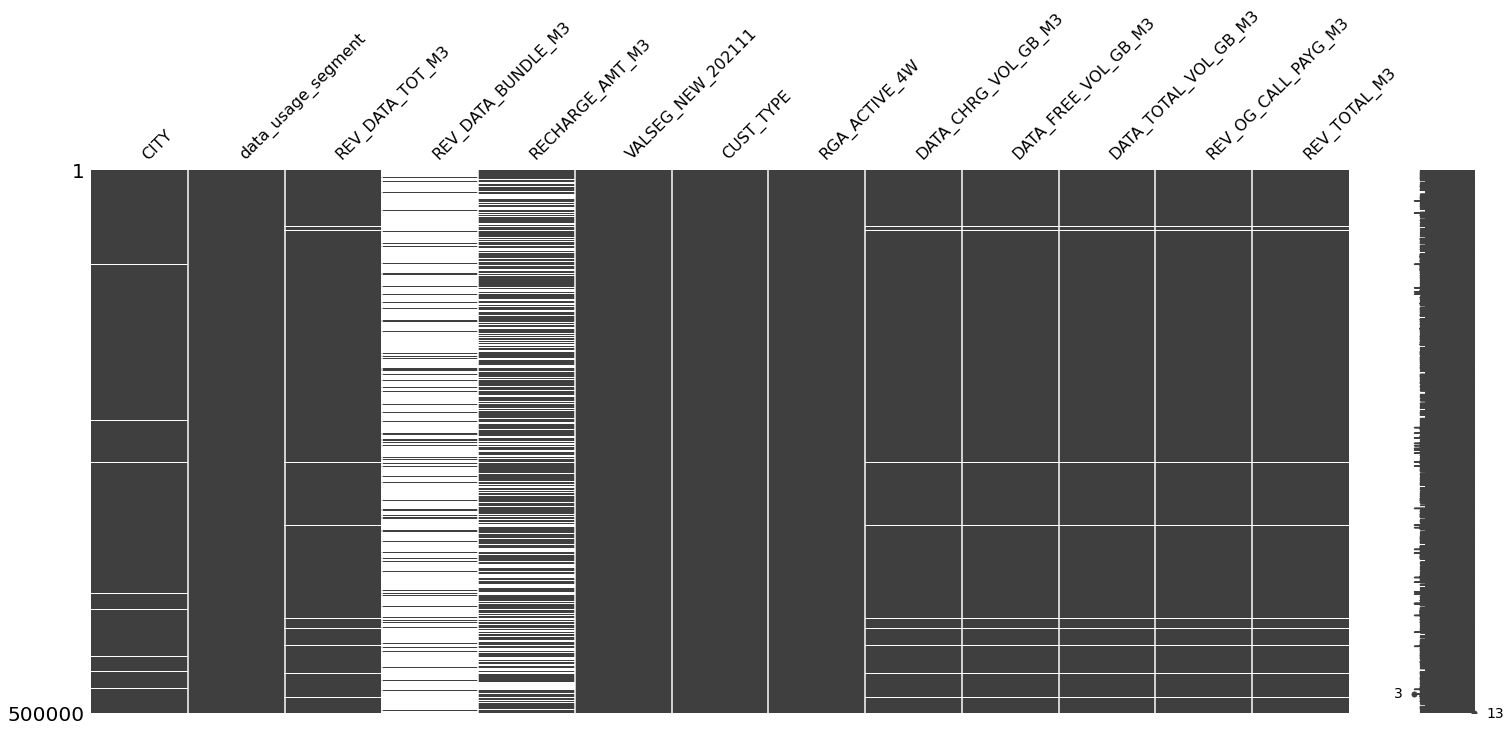

In [8]:
#Gives positional information of the missing values
msno.matrix(df_clustering)

In [9]:
# As we can see REV_DATA_BUNDLE_M3 and RECHARGE_AMT_M3 have many missing value we remove them form data fraùe

In [10]:
df_clustering = df_clustering.drop(['REV_DATA_BUNDLE_M3', 'RECHARGE_AMT_M3'], axis=1)
df_clustering.head()

,CITY,data_usage_segment,REV_DATA_TOT_M3,VALSEG_NEW_202111,CUST_TYPE,RGA_ACTIVE_4W,DATA_CHRG_VOL_GB_M3,DATA_FREE_VOL_GB_M3,DATA_TOTAL_VOL_GB_M3,REV_OG_CALL_PAYG_M3,REV_TOTAL_M3
0,Baghdad,VL,0.000000,3.M,consumer,1,0.0,0.000000,0.000000,12.965818,13.418182
1,Baghdad,Non,0.000000,5.VL,consumer,1,0.0,0.000000,0.000000,0.000000,0.000000
2,Baghdad,Non,0.000000,2.H,consumer,1,0.0,0.000000,0.000000,41.363636,41.345455
3,Suly,Ext. High,261.818182,1.HH,consumer,1,0.0,11.995288,11.995288,500.794182,773.578182
4,Baghdad,L,0.000000,3.M,consumer,1,0.0,0.000001,0.000001,14.894545,71.330909


# Data Describtion

In [11]:
df_clustering.data_usage_segment.unique()

array(['VL', 'Non', 'Ext. High', 'L', 'M', 'High'], dtype=object)

In [12]:
df_clustering.VALSEG_NEW_202111.unique()

array(['3.M', '5.VL', '2.H', '1.HH', '4.L', '6.NEW', nan], dtype=object)

In [13]:
df_clustering.describe(include='all') 

,CITY,data_usage_segment,REV_DATA_TOT_M3,VALSEG_NEW_202111,CUST_TYPE,RGA_ACTIVE_4W,DATA_CHRG_VOL_GB_M3,DATA_FREE_VOL_GB_M3,DATA_TOTAL_VOL_GB_M3,REV_OG_CALL_PAYG_M3,REV_TOTAL_M3
count,494995,500000,484242.000000,499812,500000,500000.000000,484234.000000,4.842340e+05,484234.000000,484242.000000,484242.000000
unique,18,6,NaN,6,2,NaN,NaN,NaN,NaN,NaN,NaN
top,Baghdad,Non,NaN,5.VL,consumer,NaN,NaN,NaN,NaN,NaN,NaN
freq,164104,147074,NaN,173862,462136,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,11.962911,NaN,NaN,0.959614,0.000087,1.576518e+00,1.576605,24.226628,63.720174
std,NaN,NaN,44.038748,NaN,NaN,0.196863,0.001463,6.754050e+00,6.754089,47.976129,98.234127
min,NaN,NaN,-6.636364,NaN,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-171.534546
25%,NaN,NaN,0.000000,NaN,NaN,1.000000,0.000000,0.000000e+00,0.000000,0.069273,8.378182
50%,NaN,NaN,0.000000,NaN,NaN,1.000000,0.000000,9.765625e-07,0.000002,9.240000,33.447273
75%,NaN,NaN,0.000000,NaN,NaN,1.000000,0.000000,2.958684e-01,0.296238,29.749818,72.727273


In [14]:
df_clustering.CUST_TYPE.unique()

array(['consumer', 'corporate'], dtype=object)

In [15]:
len(df_clustering[df_clustering.CUST_TYPE =='corporate'])

37864

# Method 2: K-Means with One Hot Encoding or Label encoder

In [16]:
# One hot Encoding
#df_clustering = pd.get_dummies(df_clustering, columns=["CITY","data_usage_segment","VALSEG_NEW_202111",'CUST_TYPE'])
# label_encoder for saving memorie issues
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column CITY","data_usage_segment","VALSEG_NEW_202111",'CUST_TYPE' 
df_clus_enc = df_clustering.copy()
df_clus_enc['CITY']= label_encoder.fit_transform(df_clus_enc['CITY']) 
df_clus_enc['data_usage_segment']= label_encoder.fit_transform(df_clus_enc['data_usage_segment']) 
df_clus_enc['VALSEG_NEW_202111']= label_encoder.fit_transform(df_clus_enc['VALSEG_NEW_202111']) 
df_clus_enc['CUST_TYPE']= label_encoder.fit_transform(df_clus_enc['CUST_TYPE']) 


                               

In [17]:
df_clus_enc.describe(include='all')

,CITY,data_usage_segment,REV_DATA_TOT_M3,VALSEG_NEW_202111,CUST_TYPE,RGA_ACTIVE_4W,DATA_CHRG_VOL_GB_M3,DATA_FREE_VOL_GB_M3,DATA_TOTAL_VOL_GB_M3,REV_OG_CALL_PAYG_M3,REV_TOTAL_M3
count,500000.000000,500000.000000,484242.000000,500000.000000,500000.000000,500000.000000,484234.000000,4.842340e+05,484234.000000,484242.000000,484242.000000
mean,6.740912,3.259932,11.962911,2.840238,0.075728,0.959614,0.000087,1.576518e+00,1.576605,24.226628,63.720174
std,5.443968,1.553038,44.038748,1.150678,0.264563,0.196863,0.001463,6.754050e+00,6.754089,47.976129,98.234127
min,0.000000,0.000000,-6.636364,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-171.534546
25%,2.000000,2.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.069273,8.378182
50%,4.000000,4.000000,0.000000,3.000000,0.000000,1.000000,0.000000,9.765625e-07,0.000002,9.240000,33.447273
75%,11.000000,5.000000,0.000000,4.000000,0.000000,1.000000,0.000000,2.958684e-01,0.296238,29.749818,72.727273
max,18.000000,5.000000,2338.181818,6.000000,1.000000,1.000000,0.193944,5.085283e+02,508.528270,3581.230546,3907.389091


In [18]:
# Replace Nan with 0
df_clus_enc= df_clus_enc.fillna(0)
df_clus_enc.shape

(500000, 11)

In [20]:
# take a sample o 20% for the clustering
df_clus_enc_part_20 = df_clus_enc.sample(frac = 0.2)


# KMEAN Clustering

KMeans done! Time elapsed: 41.560407638549805 seconds


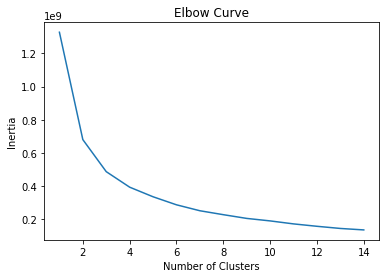

In [21]:
# Boucle pour calculer le score du modèle (via l'inertie) en fonction du nombre de clusters

time_start = time.time()

num_clusters = 15
kmeans_tests = [KMeans(n_clusters=i, init='k-means++', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(df_clus_enc_part_20).inertia_ for i in range(len(kmeans_tests))]

print('KMeans done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Représentation graphique
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')

plt.savefig("coude.png", dpi=250)

plt.show()

In [22]:
# 3 cluster seem to be goo

In [23]:
# Creation d'un modèle M-Means avec un nombre arbitraire de 3 clusters
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)

# Fit
kmeans.fit(df_clus_enc_part_20)

# Détermination des clusters pour chaque point du jeu de données
clusters =  kmeans.predict(df_clus_enc_part_20)

KMeans done! Time elapsed: 1184.396990776062 seconds


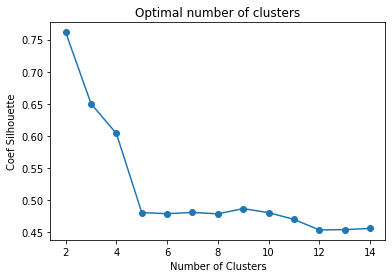

In [24]:
#Vérification avec les coefficients de silhouette
from sklearn import preprocessing, manifold, cluster, metrics, decomposition
time_start = time.time()

silhouettes = []
for num_clusters in range (2,15):
    cls = KMeans(n_clusters = num_clusters,n_init = 10,
                        init = 'k-means++')
    cls.fit(df_clus_enc_part_20)
    silh = metrics.silhouette_score(df_clus_enc_part_20, cls.labels_)
    silhouettes.append(silh)

print('KMeans done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
plt.plot(range(2,15), silhouettes, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Coef Silhouette')
plt.title('Optimal number of clusters')

plt.savefig("clustKM.png", dpi=250)

plt.show()

In [25]:
# 3 cluster seem to be better

In [26]:
#Clustering via KMeans et récupération des valeurs de cluster pour chaque point
n_clust = 3
time_start = time.time()

kmeans = KMeans(init='k-means++',
                n_clusters = n_clust,
                n_init = 10)

kmeans.fit(df_clus_enc_part_20)

clusters =  kmeans.predict(df_clus_enc_part_20)

print('KMeans done! Time elapsed: {} seconds'.format(time.time()-time_start))

KMeans done! Time elapsed: 2.102597713470459 seconds


In [27]:
#Application du t-SNE

time_start = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=500, init='pca')

X_tsne = tsne.fit_transform(df_clus_enc_part_20.values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


t-SNE done! Time elapsed: 564.6774532794952 seconds


<function matplotlib.pyplot.show(*args, **kw)>

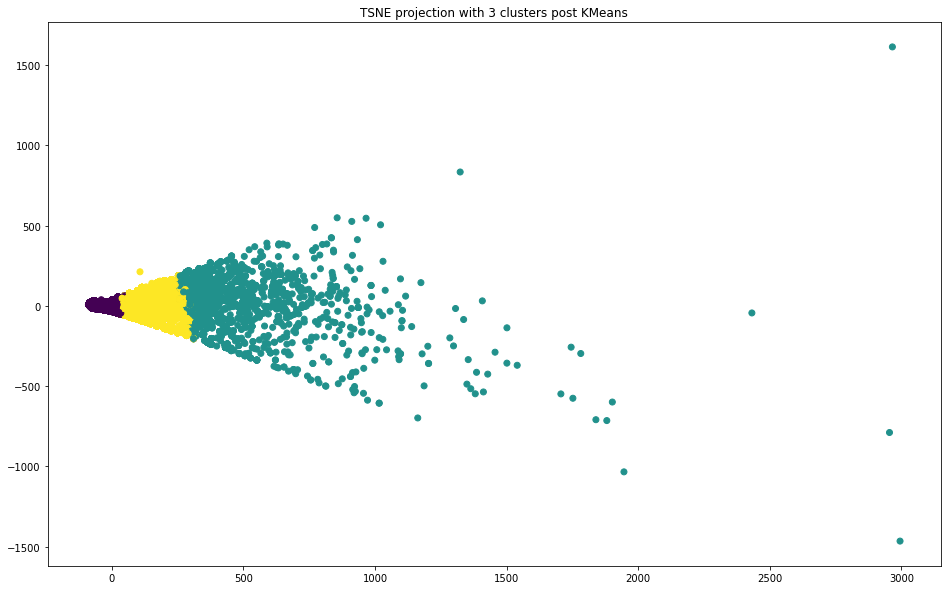

In [28]:
#Visualisation via T-SNE des clusters obtenu après le KMeans précédent

plt.figure(figsize=(16,10))

plt.scatter(X_tsne[:,0], X_tsne[:,1], c = clusters )

plt.title("TSNE projection with 3 clusters post KMeans")

#plt.savefig("TSNE_3_KM.png", dpi=250)

plt.show

## Evaluation des clustering

The DB index captures the intuition that clusters that are (1) well-spaced from each other and (2) themselves very dense are likely a ‘good’ clustering. This is because the measure’s ‘max’ statement repeatedly selects the values where the average point is farthest away from its centroid, and where the centroids are closest together. As the DB index shrinks, the clustering is considered ‘better’.

The Silhouette Coefficient tells us how well-assigned each individual point is. If S(i) is close to 0, it is right at the inflection point between two clusters. If it is closer to -1, then we would have been better off assigning it to the other cluster. If S(i) is close to 1, then the point is well-assigned and can be interpreted as belonging to an ‘appropriate’ cl

In [30]:
from sklearn.metrics import davies_bouldin_score
from sklearn import preprocessing, manifold, cluster, metrics, decomposition
print("DBI: {} and Silhouette: {} for KMeans".format(round(davies_bouldin_score(df_clus_enc_part_20 ,kmeans.labels_),4),
                                          round(metrics.silhouette_score(df_clus_enc_part_20, 
                                                                         kmeans.labels_),4)))

DBI: 0.9255 and Silhouette: 0.6501 for KMeans


In [31]:
clusters = kmeans.fit_predict(df_clus_enc)
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((df_clus_enc,labels),axis=1)
labeledCustomers = labeledCustomers.rename({0:'labels'},axis=1)
labeledCustomers.labels.unique()

array([0, 2, 1], dtype=int32)

In [32]:
df_Detailed_ADS['labels'] = labeledCustomers['labels']
df_kmeans = df_Detailed_ADS[['msisdn_id','labels']]
df_kmeans.to_csv('/content/drive/MyDrive/Assignment/df_kmeans.csv')

In [33]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates
import seaborn as sns

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster')

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)

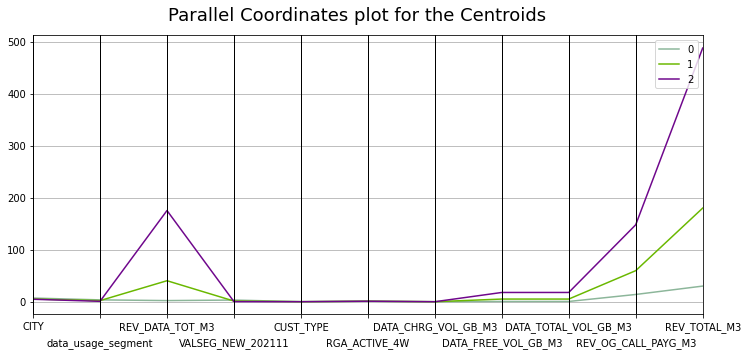

In [34]:
n_clust = 3
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_clus_enc.columns)

centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, n_clust)

plt.savefig("centro_kmean.png", dpi=250)

 # CAH Clustering

In [ ]:
# Confirmation du nombre optimal de clusters


time_start = time.time()

silhouettes = []
for num_clusters in range (2,10):
    cls = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True)
    cls.set_params(n_clusters = num_clusters)
    clusters_cah = cls.fit_predict(df_clus_enc) 
    silh = metrics.silhouette_score(df_clus_enc_part_20, clusters_cah)
    silhouettes.append(silh)

print('CAH done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
plt.plot(range(2,10), silhouettes, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Coef Silhouette')
plt.title('Optimal number of clusters')

plt.savefig("clustCAH.png", dpi=250)

plt.show()